In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [25]:
def processHubwayTripsData(hubway_trips_df):
    hubway_trips_df['start_date'] = hubway_trips_df['start_date'].apply(lambda x: parse(x))
    hubway_trips_df['year_start'] = hubway_trips_df['start_date'].apply(lambda x: x.year)
    hubway_trips_df['month_start'] = hubway_trips_df['start_date'].apply(lambda x: x.month)
    hubway_trips_df['weekday_start'] = hubway_trips_df['start_date'].apply(lambda x: x.dayofweek)
    hubway_trips_df['day_start'] = hubway_trips_df['start_date'].apply(lambda x: x.day)
    hubway_trips_df['hour_start'] = hubway_trips_df['start_date'].apply(lambda x: x.hour)
    hubway_trips_df = hubway_trips_df.rename(columns={'status': 'trip_status'})
    return hubway_trips_df

In [16]:
def mapFrequentPostalCodeToGPSData():
    dict = {'zip_code': ["'02118", "'02139", "'02215", "'02116", "'02115", "'02138", "'02114", "'02143", "'02113", "'02134" ], 
            'zip_code_lat': [42.3407, 42.3643, 42.3476, 42.3514, 42.3480, 42.34733, 42.36033, 42.38371, 42.36285, 42.35595 ],
            'zip_code_lng': [-71.0708, -71.1022, -71.1009, -71.0776, -71.0885, -71.16867, -71.06732, -71.10213, -71.05518, -71.13411  ]
           }
    return pd.DataFrame(data=dict)

In [26]:
def createMasterDataSet(hubway_trips_df, hubway_stations_df, weather_df, zip_code_gps_df):
    hubway_trips_df = processHubwayTripsData(hubway_trips_df)
    master_df = pd.merge(hubway_trips_df, hubway_stations_df, how='left', left_on='strt_statn', right_on='id')
    master_df = master_df.rename(columns={'id': 'id_start', 'terminal': 'terminal_start', 'station': 'station_start', 'municipal': 'municipal_start', 'lat': 'lat_start', 'lng': 'lng_start', 'status': 'status_start'})
    master_df = pd.merge(master_df, hubway_stations_df, how='left', left_on='end_statn', right_on='id')
    master_df = master_df.rename(columns={'id': 'id_end', 'terminal': 'terminal_end', 'station': 'station_end', 'municipal': 'municipal_end', 'lat': 'lat_end', 'lng': 'lng_end', 'status': 'status_end'})
    master_df = pd.merge(master_df, weather_df, how='left', left_on=['year_start', 'month_start', 'day_start'], right_on=['Year', 'Month', 'Day'])
    master_df = pd.merge(master_df, zip_code_gps_df, how='left', left_on=['zip_code'], right_on=['zip_code'])
    
    return master_df

In [30]:
def importData():
    hubway_stations_df = pd.read_csv('hubway_stations.csv', sep=',').sort_values(['station'], ascending=True)
    hubway_trips_df = pd.read_csv('hubway_trips.csv', sep=',')
    weather_df = pd.read_csv('boston_weather.csv', sep=',')
    zip_code_gps_df = mapFrequentPostalCodeToGPSData()
    
    return hubway_trips_df, hubway_stations_df, weather_df, zip_code_gps_df

In [115]:
def createFeatures(master_df):
    
    master_df['same_st_flg'] = np.where(master_df['strt_statn'] == master_df['end_statn'], 1, 0)
    master_df['age'] = master_df[(master_df['subsc_type']=='Registered') ]['year_start'] - master_df[(master_df['subsc_type']=='Registered') ]['birth_date']
    
    bins = [0, 2, 4, 6, 8, np.inf]
    names = ['0-2', '2-4', '4-6','6-8', '8+']
    master_df['Avg Visibility Range (mi)'] = pd.cut(master_df['Avg Visibility (mi)'], bins, labels=names)

    bins = [20, 40, 60, 80, np.inf]
    names = ['20-40', '40-60', '60-80','80+']
    master_df['Avg Temp Range (F)'] = pd.cut(master_df['Avg Temp (F)'], bins, labels=names)

    bins = [20, 40, 60, 80, np.inf]
    names = ['20-40', '40-60', '60-80','80+']
    master_df['Avg Humidity Range (%)'] = pd.cut(master_df['Avg Humidity (%)'], bins, labels=names)

    bins = [0, 5, 10, 15, np.inf]
    names = ['0-5', '5-10', '10-15','15+']
    master_df['Avg Wind Range (mph)'] = pd.cut(master_df['Avg Wind (mph)'], bins, labels=names)

    bins = [0, 20, 40, 60, np.inf]
    names = ['0-20', '20-40', '40-60','60+']
    master_df['Avg Dew Point Range (F)'] = pd.cut(master_df['Avg Dew Point (F)'], bins, labels=names)

    bins = [0, 20, 40, 60, np.inf]
    names = ['0-20', '20-40', '40-60','60+']
    master_df['Age Range'] = pd.cut(master_df[(master_df['subsc_type']=='Registered') ]['age'], bins, labels=names)
    
    
    bike_agg = master_df[['bike_nr', 'seq_id', 'duration']].groupby(by=['bike_nr']).agg(bike_use_cnt=('seq_id', 'count'), bike_ride_duration_avg=('duration', 'mean')).sort_values(["bike_use_cnt"], ascending = (False)).reset_index() 
    master_df = pd.merge(master_df, bike_agg, how='left', left_on=['bike_nr'], right_on=['bike_nr'])
    
    bins = [0, 500, 1000, 1500, np.inf]
    names = ['0-500', '500-1000', '1000-1500','1500+']
    master_df['Bike Use Range'] = pd.cut(master_df['bike_use_cnt'], bins, labels=names)
    
    bins = [500, 1000, 1500, np.inf]
    names = ['500-1000', '1000-1500','1500+']
    master_df['Bike Avg Time Use Range'] = pd.cut(master_df['bike_ride_duration_avg'], bins, labels=names)
    
    return master_df


In [238]:
def plotSpatialDataClusterStations(feature_set, hubway_stations_df):
    city_map = plt.imread('boston_map.png')
    BBox = ((hubway_stations_df.lng.min(), hubway_stations_df.lng.max(), hubway_stations_df.lat.min(), hubway_stations_df.lat.max()))

    fig, ax = plt.subplots(figsize = (8,7))
    clusters = np.unique(feature_set['location_cluster'])
    for i in clusters:
        ax.scatter(feature_set[feature_set['location_cluster']==i].longitude, feature_set[feature_set['location_cluster']==i].latitude, zorder=1, alpha= 1.0, s=30, label = i)
        
    ax.set_title('Bike Station Locations Grouped in Clusters')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.imshow(city_map, zorder=0, extent = BBox, aspect= 'equal')
    labels = clusters
    plt.legend(labels)

In [46]:
def plotSpatialDataAllStations(master_df, hubway_stations_df):
    city_map = plt.imread('boston_map.png')
    BBox = ((hubway_stations_df.lng.min(), hubway_stations_df.lng.max(), hubway_stations_df.lat.min(), hubway_stations_df.lat.max()))
    most_used_stations = master_df[['strt_statn', 'lat_start', 'lng_start', 'seq_id']].groupby(by=['strt_statn', 'lat_start', 'lng_start']).agg(use_cnt=('seq_id', 'count')).sort_values(["use_cnt"], ascending = (False)).reset_index().head(10)
    least_used_stations = master_df[['strt_statn', 'lat_start', 'lng_start', 'seq_id']].groupby(by=['strt_statn', 'lat_start', 'lng_start']).agg(use_cnt=('seq_id', 'count')).sort_values(["use_cnt"], ascending = (True)).reset_index().head(10)
    fig, ax = plt.subplots(figsize = (8,7))
    ax.scatter(hubway_stations_df.lng, hubway_stations_df.lat, zorder=1, alpha= 1.0, c='b', s=30)
    ax.scatter(most_used_stations.lng_start, most_used_stations.lat_start, zorder=1, alpha= 1.0, c='g', s=30)
    ax.scatter(least_used_stations.lng_start, least_used_stations.lat_start, zorder=1, alpha= 1.0, c='r', s=30)
    ax.set_title('Bike Station Locations Grouped by Use Frequency')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.imshow(city_map, zorder=0, extent = BBox, aspect= 'equal')
    labels = ["Regular", "Most Used", "Least Used"]
    plt.legend(labels)

In [50]:
def plotSpatialDataStationInteractions(master_df, hubway_stations_df):
    
    city_map = plt.imread('boston_map.png')
    BBox = ((hubway_stations_df.lng.min(), hubway_stations_df.lng.max(), hubway_stations_df.lat.min(), hubway_stations_df.lat.max()))
    stat_interactions = master_df[['strt_statn', 'end_statn', 'lat_start', 'lng_start', 'lat_end', 'lng_end', 'seq_id', 'duration']].groupby(by=['strt_statn', 'end_statn','lat_start', 'lng_start', 'lat_end', 'lng_end']).agg(use_cnt=('seq_id', 'count'), duration_avg=('duration', 'mean')).sort_values(["use_cnt"], ascending = (False)).reset_index().head(30)
    fig, ax = plt.subplots(figsize = (8,7))
    ax.scatter(stat_interactions.lng_start, stat_interactions.lat_start, zorder=1, alpha= 0.3, c='b', s=100)
    ax.scatter(stat_interactions.lng_end, stat_interactions.lat_end, zorder=1, alpha= 0.3, c='b', s=100)
    
    ax.set_title('Stations With The Most Frequent Interactions')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.imshow(city_map, zorder=0, extent = BBox, aspect= 'equal')

    X_coords = [stat_interactions.lng_start, stat_interactions.lng_end]
    Y_coords = [stat_interactions.lat_start, stat_interactions.lat_end]
    plt.plot(X_coords, Y_coords, color='red')

    plt.show()

In [58]:
def plotSpatialDataUserZIPCodes(zip_code_gps_df):
    city_map = plt.imread('boston_map.png')
    BBox = ((zip_code_gps_df.zip_code_lng.min(), zip_code_gps_df.zip_code_lng.max(), zip_code_gps_df.zip_code_lat.min(), zip_code_gps_df.zip_code_lat.max()))
    fig, ax = plt.subplots(figsize = (8,7))
    ax.scatter(zip_code_gps_df.zip_code_lng, zip_code_gps_df.zip_code_lat, zorder=1, alpha= 1.0, c='b', s=30)
    ax.set_title('User Residence Areas With The Highest Frequency of Bike Use')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.imshow(city_map, zorder=0, extent = BBox, aspect= 'equal')
    labels = ["User Residence Area"]
    plt.legend(labels)

In [60]:
def plotSpatialDataUserZIPCodeInteractions(master_df):
    zipcode_interactions = master_df[['zip_code', 'id_start', 'lat_start', 'lng_start', 'zip_code_lat', 'zip_code_lng', 'seq_id']].groupby(by=['zip_code', 'id_start', 'lat_start', 'lng_start', 'zip_code_lat', 'zip_code_lng']).agg(use_cnt=('seq_id', 'count')).sort_values(["use_cnt"], ascending = (False)).reset_index().head(4)
    city_map = plt.imread('boston_map.png')
    BBox = ((zipcode_interactions.lng_start.min(), zipcode_interactions.lng_start.max(), zipcode_interactions.lat_start.min(), zipcode_interactions.lat_start.max()))
    fig, ax = plt.subplots(figsize = (8,7))
    ax.scatter(zipcode_interactions.zip_code_lng, zipcode_interactions.zip_code_lat, zorder=1, alpha= 0.3, c='b', s=100)
    ax.scatter(zipcode_interactions.lng_start, zipcode_interactions.lat_start, zorder=1, alpha= 0.3, c='b', s=100)
    
    ax.set_title('User Residence Area With The Highest Station Interaction')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.imshow(city_map, zorder=0, extent = BBox, aspect= 'equal')

    X_coords = [zipcode_interactions.zip_code_lng, zipcode_interactions.lng_start]
    Y_coords = [zipcode_interactions.zip_code_lat, zipcode_interactions.lat_start]
    plt.plot(X_coords, Y_coords, color='red')

    plt.show()

In [62]:
def plotHistDistDuration(master_df, municipality):
    plt.hist(master_df[(master_df['municipal_start']==municipality) & (master_df['subsc_type'] == 'Registered') ]['duration'],range = (0, 3000), bins = 20, alpha = 0.5)
    plt.hist(master_df[(master_df['municipal_start']==municipality) & (master_df['subsc_type'] == 'Casual') ]['duration'],range = (0, 3000), bins = 20, alpha = 0.5)
    plt.title('Frequency Distribution of Trip Duration for ' + municipality)
    plt.xlabel('Duration (s)')
    plt.ylabel('Number of Trips')
    
    labels = ["Registered", "Casual"]
    plt.legend(labels)
    plt.show()

In [67]:
def plotHistDistVar(master_df, title, xlabel, ylabel, var, start, end, bins_cnt):
    plt.hist(master_df[var],range = (start, end), bins = bins_cnt)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [77]:
def plotUserTypeStackData(master_df, title, group_var, variable, labels, label_x, label_y):        
        month_use_counts = master_df[[group_var, 'subsc_type', 'seq_id', 'duration']].groupby(by=[group_var, 'subsc_type']).agg(use_cnt=('seq_id', 'count'), duration_avg=('duration', 'mean')).reset_index().sort_values([group_var, 'subsc_type'], ascending=(True, True))
        reg_pct = month_use_counts[(month_use_counts['subsc_type']=='Registered')][variable]
        cas_pct = month_use_counts[(month_use_counts['subsc_type']=='Casual')][variable]
        
        width = 0.8 

        fig, ax = plt.subplots()

        ax.bar(labels, reg_pct, width, label='Registered')
        ax.bar(labels, cas_pct, width, bottom=reg_pct,
               label='Casual')

        ax.set_ylabel(label_y)
        ax.set_xlabel(label_x)
        ax.set_title(title)
        ax.legend()
        
        # Matplotlib idiom to reverse legend entries 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))


        plt.show()

In [112]:
def plotUserGenderStackData(master_df, title, group_var, variable, labels, label_x, label_y):        
        month_use_counts = master_df[[group_var, 'subsc_type', 'gender', 'seq_id', 'duration']].groupby(by=[group_var, 'subsc_type', 'gender']).agg(use_cnt=('seq_id', 'count'), duration_avg=('duration', 'mean')).reset_index().sort_values([group_var, 'gender'], ascending=(True, True))
        reg_pct = month_use_counts[(month_use_counts['subsc_type']=='Registered') & (month_use_counts['gender']=='Male') ][variable]
        cas_pct = month_use_counts[(month_use_counts['subsc_type']=='Registered') & (month_use_counts['gender']=='Female') ][variable]
        
        width = 0.8 # the width of the bars: can also be len(x) sequence

        fig, ax = plt.subplots()

        ax.bar(labels, reg_pct, width, label='Male')
        ax.bar(labels, cas_pct, width, bottom=reg_pct,
               label='Female')

        ax.set_ylabel(label_y)
        ax.set_xlabel(label_x)
        ax.set_title(title)
        ax.legend()
        
        # Matplotlib idiom to reverse legend entries 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))


        plt.show()

In [164]:
hubway_trips_df, hubway_stations_df, weather_df, zip_code_gps_df = importData()

In [165]:
master_df = createMasterDataSet(hubway_trips_df, hubway_stations_df, weather_df, zip_code_gps_df)

In [166]:
master_df = createFeatures(master_df)

In [39]:
same_st_flg_counts = master_df[['same_st_flg', 'seq_id']].groupby(by=['same_st_flg']).count().reset_index().sort_values(['seq_id'], ascending=False)
same_st_flg_ratio = same_st_flg_counts['seq_id'][same_st_flg_counts['same_st_flg'] == 1].iloc[0]/same_st_flg_counts['seq_id'][same_st_flg_counts['same_st_flg'] == 0].iloc[0]
print("Share of bike rides that start and finish at the same station: ", round(same_st_flg_ratio*100,2), '%')

Share of bike rides that start and finish at the same station:  5.08 %


In [52]:
mun_interactions  = master_df[['municipal_start', 'municipal_end', "duration", 'seq_id']].groupby(by=['municipal_start', 'municipal_end']).agg(use_cnt=('seq_id', 'count'), duration_avg=('duration', 'mean')).sort_values(["use_cnt"], ascending = (False)).reset_index()
#mun_interactions

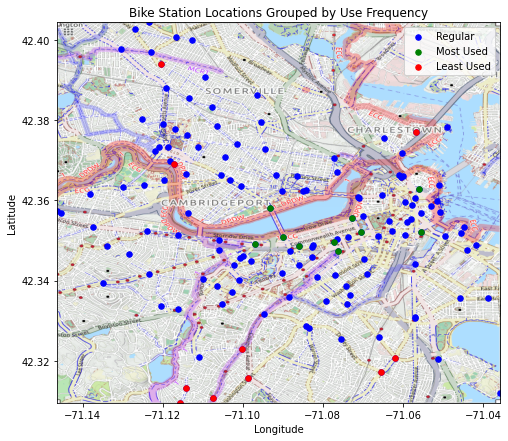

In [47]:
plotSpatialDataAllStations(master_df, hubway_stations_df)

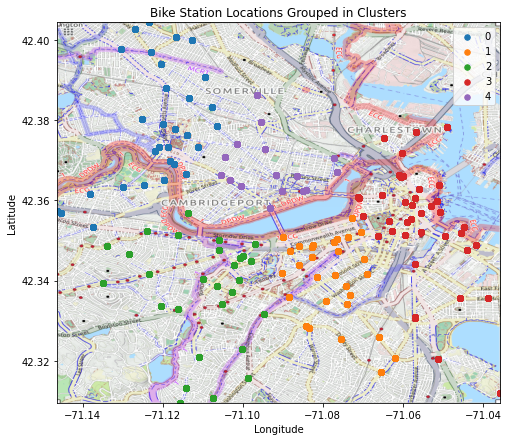

In [240]:
plotSpatialDataClusterStations(feature_set, hubway_stations_df)

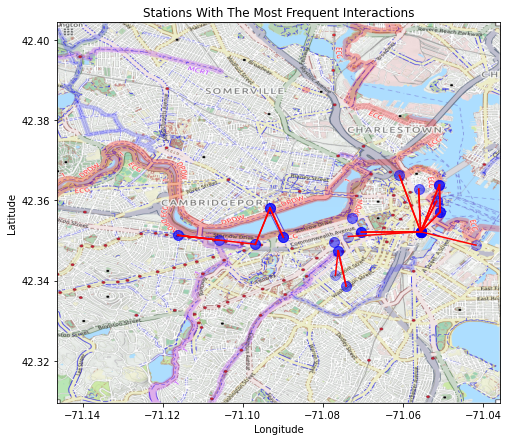

In [51]:
plotSpatialDataStationInteractions(master_df, hubway_stations_df)

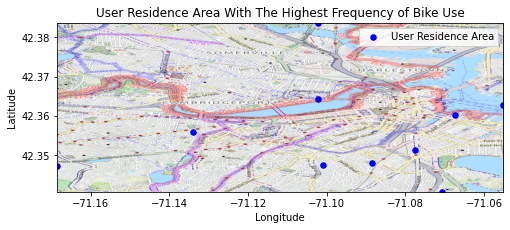

In [59]:
plotSpatialDataUserZIPCodes(zip_code_gps_df)

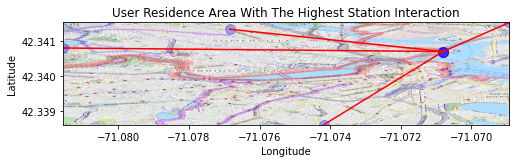

In [61]:
plotSpatialDataUserZIPCodeInteractions(master_df)

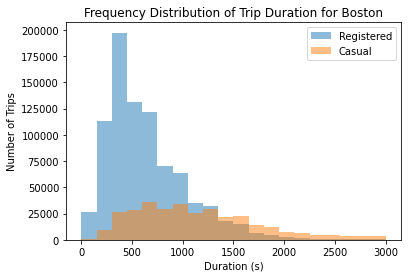

In [63]:
plotHistDistDuration(master_df, 'Boston')

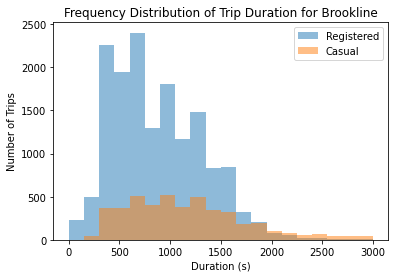

In [64]:
plotHistDistDuration(master_df, 'Brookline')

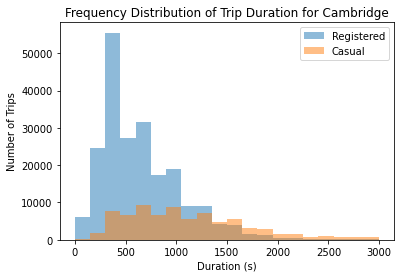

In [65]:
plotHistDistDuration(master_df, 'Cambridge')

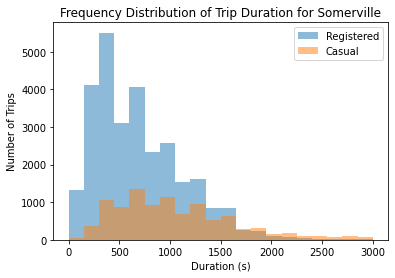

In [66]:
plotHistDistDuration(master_df, 'Somerville')

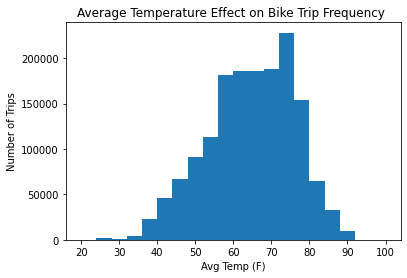

In [69]:
plotHistDistVar(master_df, 
                'Average Temperature Effect on Bike Trip Frequency ', 
                'Avg Temp (F)', 
                'Number of Trips', 
                'Avg Temp (F)', 
                20, 
                100, 
                20)

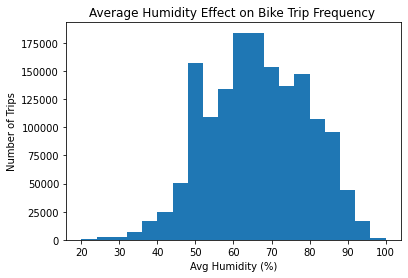

In [71]:
plotHistDistVar(master_df, 
                'Average Humidity Effect on Bike Trip Frequency ', 
                'Avg Humidity (%)', 
                'Number of Trips', 
                'Avg Humidity (%)', 
                20, 
                100, 
                20)

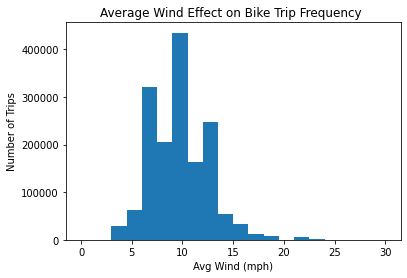

In [73]:
plotHistDistVar(master_df, 
                'Average Wind Effect on Bike Trip Frequency ', 
                'Avg Wind (mph)', 
                'Number of Trips', 
                'Avg Wind (mph)', 
                0, 
                30, 
                20)

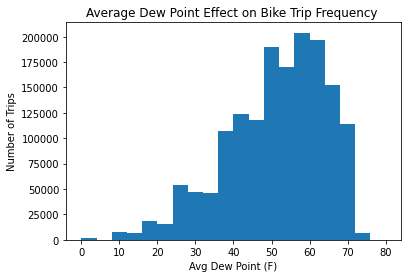

In [74]:
plotHistDistVar(master_df, 
                'Average Dew Point Effect on Bike Trip Frequency ', 
                'Avg Dew Point (F)', 
                'Number of Trips', 
                'Avg Dew Point (F)', 
                0, 
                80, 
                20)

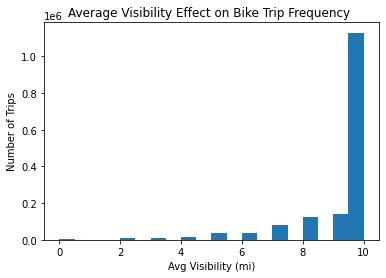

In [75]:
plotHistDistVar(master_df, 
                'Average Visibility Effect on Bike Trip Frequency ', 
                'Avg Visibility (mi)', 
                'Number of Trips', 
                'Avg Visibility (mi)', 
                0, 
                10, 
                20)

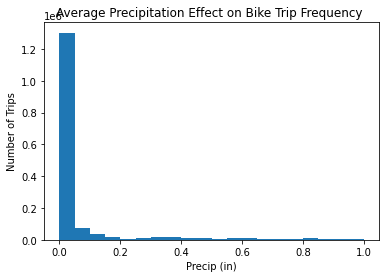

In [76]:

plotHistDistVar(master_df, 
                'Average Precipitation Effect on Bike Trip Frequency ', 
                'Precip (in)', 
                'Number of Trips', 
                'Precip (in)', 
                0, 
                1, 
                20)

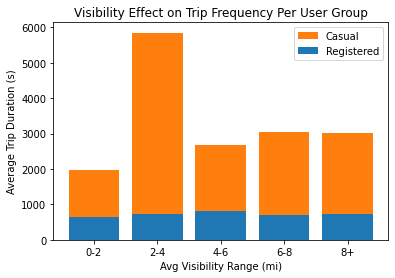

In [138]:
plotUserTypeStackData(master_df,
                                 'Visibility Effect on Trip Frequency Per User Group',
                                  'Avg Visibility Range (mi)',
                                 'duration_avg',
                                 ['0-2', '2-4', '4-6','6-8', '8+'],
                                 'Avg Visibility Range (mi)',
                                 'Average Trip Duration (s)')

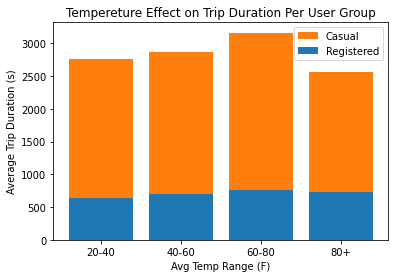

In [139]:
plotUserTypeStackData(master_df,
                                 'Tempereture Effect on Trip Duration Per User Group',
                                 'Avg Temp Range (F)',
                                 'duration_avg',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Temp Range (F)',
                                 'Average Trip Duration (s)')

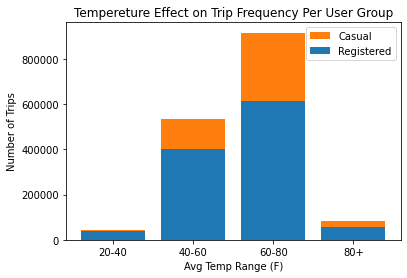

In [140]:
plotUserTypeStackData(master_df,
                                 'Tempereture Effect on Trip Frequency Per User Group',
                                 'Avg Temp Range (F)',
                                 'use_cnt',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Temp Range (F)',
                                 'Number of Trips')

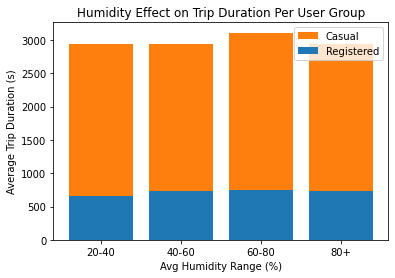

In [141]:
plotUserTypeStackData(master_df,
                                 'Humidity Effect on Trip Duration Per User Group',
                                 'Avg Humidity Range (%)',
                                 'duration_avg',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Humidity Range (%)',
                                 'Average Trip Duration (s)')

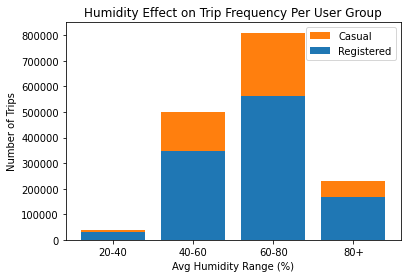

In [142]:
plotUserTypeStackData(master_df,
                                 'Humidity Effect on Trip Frequency Per User Group',
                                 'Avg Humidity Range (%)',
                                 'use_cnt',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Humidity Range (%)',
                                 'Number of Trips')

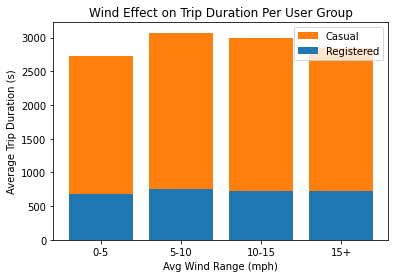

In [143]:
plotUserTypeStackData(master_df,
                                 'Wind Effect on Trip Duration Per User Group',
                                 'Avg Wind Range (mph)',
                                 'duration_avg',
                                 ['0-5', '5-10', '10-15','15+'],
                                 'Avg Wind Range (mph)',
                                 'Average Trip Duration (s)')

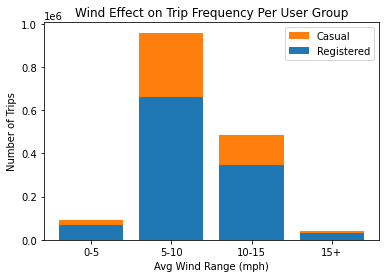

In [144]:
plotUserTypeStackData(master_df,
                                 'Wind Effect on Trip Frequency Per User Group',
                                 'Avg Wind Range (mph)',
                                 'use_cnt',
                                 ['0-5', '5-10', '10-15','15+'],
                                 'Avg Wind Range (mph)',
                                 'Number of Trips')

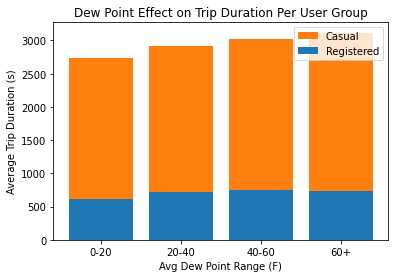

In [145]:
plotUserTypeStackData(master_df,
                                 'Dew Point Effect on Trip Duration Per User Group',
                                 'Avg Dew Point Range (F)',
                                 'duration_avg',
                                 ['0-20', '20-40', '40-60','60+'],
                                 'Avg Dew Point Range (F)',
                                 'Average Trip Duration (s)')

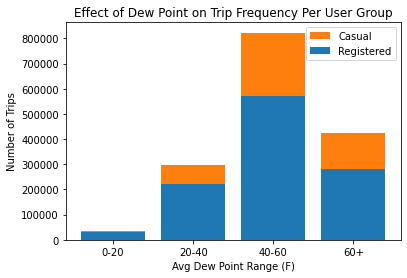

In [136]:
plotUserTypeStackData(master_df,
                                 'Effect of Dew Point on Trip Frequency Per User Group',
                                 'Avg Dew Point Range (F)',
                                 'use_cnt',
                                 ['0-20', '20-40', '40-60','60+'],
                                 'Avg Dew Point Range (F)',
                                 'Number of Trips')

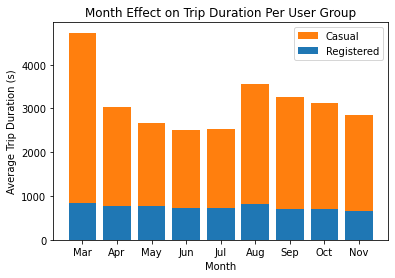

In [153]:
plotUserTypeStackData(master_df,
                                 'Month Effect on Trip Duration Per User Group',
                                 'month_start',
                                 'duration_avg',
                                 ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'],
                                 'Month',
                                 'Average Trip Duration (s)')

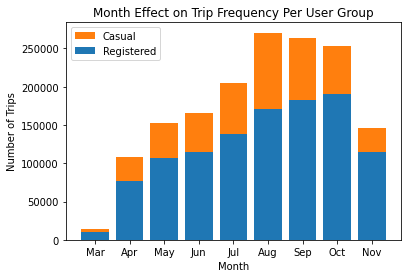

In [149]:
plotUserTypeStackData(master_df,
                                 'Month Effect on Trip Frequency Per User Group',
                                 'month_start',
                                 'use_cnt',
                                 ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'],
                                 'Month',
                                 'Number of Trips')

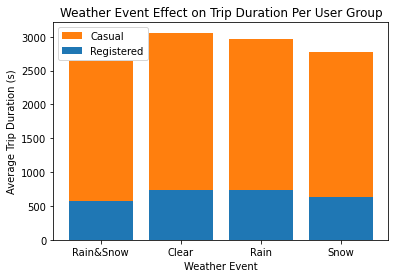

In [155]:
plotUserTypeStackData(master_df,
                                 'Weather Event Effect on Trip Duration Per User Group',
                                 'Events',
                                 'duration_avg',
                                 ['Rain&Snow', 'Clear', 'Rain', 'Snow'],
                                 'Weather Event',
                                 'Average Trip Duration (s)')

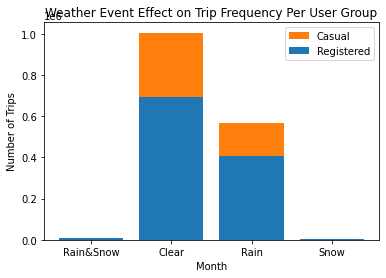

In [156]:
plotUserTypeStackData(master_df,
                                 'Weather Event Effect on Trip Frequency Per User Group',
                                 'Events',
                                 'use_cnt',
                                 ['Rain&Snow', 'Clear', 'Rain', 'Snow'],
                                 'Month',
                                 'Number of Trips')

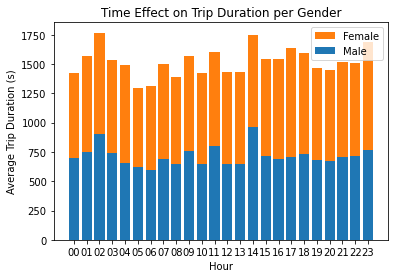

In [133]:
plotUserGenderStackData(master_df,
                                 'Time Effect on Trip Duration per Gender',
                                 'hour_start',
                                 'duration_avg',
                                 ['00', '01', '02','03', '04', '05', '06','07', '08', '09', '10','11', '12', '13', '14','15', '16', '17', '18','19', '20', '21', '22','23'],
                                 'Hour',
                                 'Average Trip Duration (s)')

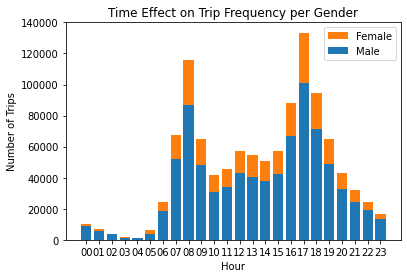

In [132]:
plotUserGenderStackData(master_df,
                                 'Time Effect on Trip Frequency per Gender',
                                 'hour_start',
                                 'use_cnt',
                                 ['00', '01', '02','03', '04', '05', '06','07', '08', '09', '10','11', '12', '13', '14','15', '16', '17', '18','19', '20', '21', '22','23'],
                                 'Hour',
                                 'Number of Trips')

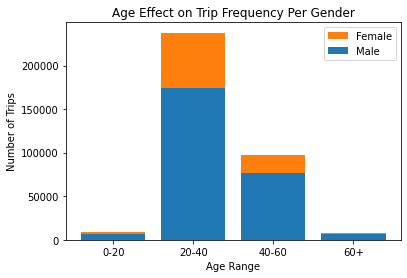

In [131]:
plotUserGenderStackData(master_df,
                                 'Age Effect on Trip Frequency Per Gender',
                                 'Age Range',
                                 'use_cnt',
                                 ['0-20', '20-40', '40-60','60+'],
                                 'Age Range',
                                 'Number of Trips')

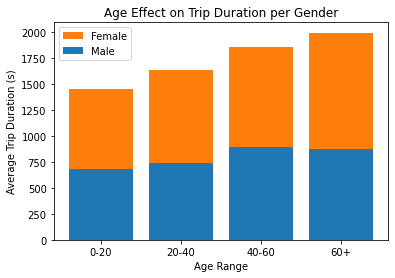

In [130]:
plotUserGenderStackData(master_df,
                                 'Age Effect on Trip Duration per Gender',
                                 'Age Range',
                                 'duration_avg',
                                 ['0-20', '20-40', '40-60','60+'],
                                 'Age Range',
                                 'Average Trip Duration (s)')

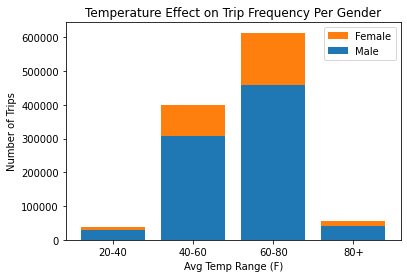

In [128]:
plotUserGenderStackData(master_df,
                                 'Temperature Effect on Trip Frequency Per Gender',
                                 'Avg Temp Range (F)',
                                 'use_cnt',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Temp Range (F)',
                                 'Number of Trips')

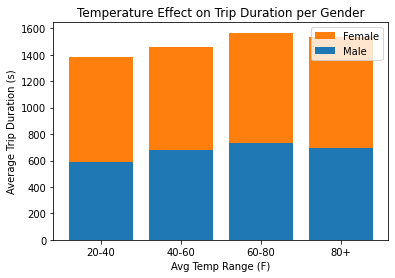

In [129]:
plotUserGenderStackData(master_df,
                                 'Temperature Effect on Trip Duration per Gender',
                                 'Avg Temp Range (F)',
                                 'duration_avg',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Temp Range (F)',
                                 'Average Trip Duration (s)')

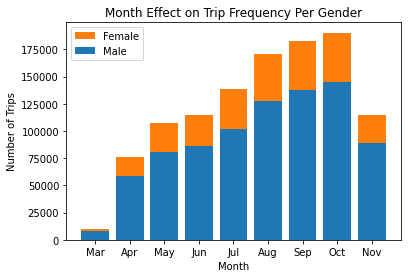

In [134]:
plotUserGenderStackData(master_df,
                                 'Month Effect on Trip Frequency Per Gender',
                                 'month_start',
                                 'use_cnt',
                                 ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'],
                                 'Month',
                                 'Number of Trips')

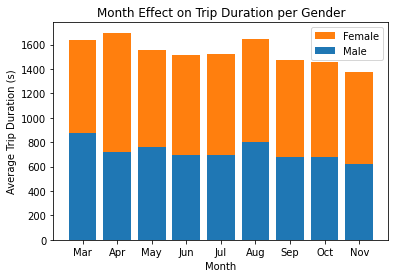

In [135]:
plotUserGenderStackData(master_df,
                                 'Month Effect on Trip Duration per Gender',
                                 'month_start',
                                 'duration_avg',
                                 ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'],
                                 'Month',
                                 'Average Trip Duration (s)')

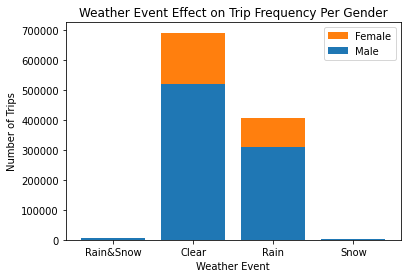

In [151]:
plotUserGenderStackData(master_df,
                                 'Weather Event Effect on Trip Frequency Per Gender',
                                 'Events',
                                 'use_cnt',
                                 ['Rain&Snow', 'Clear', 'Rain', 'Snow'],
                                 'Weather Event',
                                 'Number of Trips')

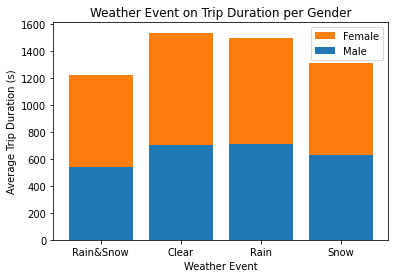

In [152]:
plotUserGenderStackData(master_df,
                                 'Weather Event on Trip Duration per Gender',
                                 'Events',
                                 'duration_avg',
                                 ['Rain&Snow', 'Clear', 'Rain', 'Snow'],
                                 'Weather Event',
                                 'Average Trip Duration (s)')

In [582]:
feature_set = master_df[[
    'municipal_start',
    'lat_start',
    'lng_start',
    'status_start',
    'trip_status',
    'year_start',
    'month_start',
    'weekday_start',
    'day_start',
    'hour_start',
    'subsc_type',
    'zip_code',
    'gender',
    'age',
    'Bike Use Range',
    'Bike Avg Time Use Range',
    'Avg Temp (F)',
    'Avg Dew Point (F)',
    'Avg Humidity (%)',
    'Avg Sea Level Press (in)',
    'Avg Visibility (mi)',
    'Avg Wind (mph)',
    'Snowfall (in)',
    'Precip (in)',
    'Events',
    'duration'
]]

In [583]:
feature_set = feature_set.rename(
    columns={'lat_start': 'latitude',
             'lng_start': 'longitude',
             'year_start': 'year', 
             'month_start': 'month', 
             'weekday_start': 'weekday', 
             'day_start': 'day', 
             'hour_start': 'hour',
             'municipal_start': 'staton_municipality',
             'status_start': 'station_status',
             'Bike Use Range': 'bike_freq_use_range',
             'Bike Avg Time Use Range': 'bike_avg_dur_range',
             'Avg Temp (F)': 'avg_tmp_f',
             'Avg Dew Point (F)': 'avg_dew_point_f',
             'Avg Humidity (%)': 'avg_humidity_pct',
             'Avg Sea Level Press (in)': 'avg_sea_level_press_in',
             'Avg Visibility (mi)': 'avg_visibility_mi',
             'Avg Wind (mph)': 'avg_wind_mph',
             'Snowfall (in)': 'sbowfall_in',
             'Precip (in)': 'precip_in',
             'Events': 'weather_event'    
            })
 

In [584]:
#for col in feature_set.columns:
    #print(col)

In [487]:
len(feature_set[(feature_set["duration"]>0) & (feature_set["duration"]<=3000)])

1512827

In [488]:
len(feature_set)

1579025

In [491]:
feature_set["duration"].mean()

775.2984088729247

In [585]:
feature_set = feature_set[(feature_set["duration"]>0) & (feature_set["duration"]<=3000)]

In [586]:
feature_set = feature_set.drop(feature_set[feature_set['latitude'].isnull()].index)
feature_set = feature_set.drop(feature_set[feature_set['longitude'].isnull()].index)

In [587]:
feature_set["bike_freq_use_range"] = feature_set["bike_freq_use_range"].astype('object')
feature_set["bike_avg_dur_range"] = feature_set["bike_avg_dur_range"].astype('object')

In [588]:
feature_set.loc[feature_set.age.isnull(), "age"] = 0
feature_set.loc[feature_set.gender.isnull(), "gender"] = 'NULL'
feature_set.loc[feature_set.bike_freq_use_range.isnull(), "bike_freq_use_range"] = 'NULL'
feature_set.loc[feature_set.bike_avg_dur_range.isnull(), "bike_avg_dur_range"] = 'NULL'

In [589]:
feature_set["bike_freq_use_range"] = feature_set["bike_freq_use_range"].astype('category')
feature_set["bike_avg_dur_range"] = feature_set["bike_avg_dur_range"].astype('category')
feature_set["staton_municipality"] = feature_set["staton_municipality"].astype('category')
feature_set["station_status"] = feature_set["station_status"].astype('category')
feature_set["trip_status"] = feature_set["trip_status"].astype('category')
feature_set["subsc_type"] = feature_set["subsc_type"].astype('category')
feature_set["zip_code"] = feature_set["zip_code"].astype('category')
feature_set["gender"] = feature_set["gender"].astype('category')
feature_set["weather_event"] = feature_set["weather_event"].astype('category')

In [523]:
# create 5 clusters using k-means clustering algorithm.
kmeans = KMeans(5)
clusters = kmeans.fit_predict(feature_set[['latitude','longitude']])

In [590]:
feature_set['location_cluster'] = kmeans.predict(feature_set[['latitude','longitude']])

In [591]:
feature_set["location_cluster"] = feature_set["location_cluster"].astype('category')

In [592]:
category_features_ohc = pd.get_dummies(feature_set[['staton_municipality',
                                                 'subsc_type', 
                                                 'gender', 
                                                 'bike_freq_use_range',
                                                 'bike_avg_dur_range',
                                                 'weather_event',
                                                 'location_cluster'
                                                ]])

In [593]:
feature_set = feature_set.drop(columns=['staton_municipality',
                                        'subsc_type', 
                                        'gender', 
                                        'bike_freq_use_range',
                                        'bike_avg_dur_range',
                                        'weather_event',
                                        'station_status', 
                                        'trip_status', 
                                        'zip_code',
                                        'location_cluster',
                                        'year'
                                                ])

In [594]:
feature_set = feature_set.join(category_features_ohc)

In [426]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [595]:
X = feature_set.drop(columns=['duration'])
y = pd.Series(feature_set['duration'])

In [596]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [385]:
from sklearn.ensemble import GradientBoostingRegressor

lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=0.1)


In [386]:
# Fit models
lower_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.1, loss='quantile')

In [387]:
# Record actual values on test set
predictions = pd.DataFrame(y_test)
# Predict
predictions['lower'] = lower_model.predict(X_test)

In [388]:
predictions

,duration,lower
908692,1140,449.019265
298280,1391,242.933495
1343359,720,275.203545
1335450,1020,396.005619
1334875,660,240.000000
...,...,...
33449,455,240.000000
1213659,480,240.000000
1202364,600,329.525471
730009,1500,470.277925


In [598]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=5
)

In [599]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [600]:
feature_importance = pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns=X.columns)

In [601]:
y_pred = regressor.predict(X_test)

In [602]:
mean_squared_error(y_test, y_pred)

202547.12946994515

In [603]:
feature_importance.T.sort_values(by=0, ascending=False).head(15)

,0
subsc_type_Casual,0.639013
gender_Female,0.059484
location_cluster_2,0.045259
weather_event_None,0.022027
weekday,0.021773
location_cluster_1,0.020052
location_cluster_0,0.019170
longitude,0.016790
staton_municipality_Brookline,0.016674
gender_Male,0.014573
